<a href="https://colab.research.google.com/github/jydiw/ames-housing/blob/master/ames_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression with Ames Housing Dataset

A simple regression analysis of the Ames Housing datset, originally posted at [Ames, Iowa: Alternative to the Boston Housing Data as an
End of Semester Regression Project](http://jse.amstat.org/v19n3/decock.pdf) by Dean De Cock.

Test-train splits will be downloaded from [Kaggle: House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

The notebook will be split into the following sections:

- Exploratory Data Analysis (EDA)
- Linear Regression
- Regularized Regression
- Random Forest Regression

# EDA

- import data
- clean up the dataframe
- engineer custom columns
- combine EDA steps into a single function
- examine highest correlations

In [4]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt  
import seaborn as sns

## Import Data

In [44]:
# download the data from kaggle.com and save locally

train = pd.read_csv('./data/raw/train.csv')
test = pd.read_csv('./data/raw/test.csv')
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [45]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

## Clean up the Dataframe

- rename columns
- clean `NaN` values
- assign correct data types

### Rename Columns to Snake Case

This is just a personal preference.

In [46]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [47]:
train.columns = map(camel_to_snake, train.columns)
test.columns = map(camel_to_snake, test.columns)
train.columns

Index(['id', 'ms_sub_class', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
       'land_slope', 'neighborhood', 'condition1', 'condition2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod_add', 'roof_style', 'roof_matl', 'exterior1st',
       'exterior2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmt_fin_type1', 'bsmt_fin_sf1', 'bsmt_fin_type2', 'bsmt_fin_sf2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abv_gr', 'kitchen_abv_gr', 'kitchen_qual',
       'tot_rms_abv_grd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish'

### Clean `NaN` Values

In [48]:
def describe_nan(df, show_all=False, ascending=False):

    nan_df = pd.DataFrame(index=[df.columns], 
                           columns=['dtype', 'sum_na', 'mean_na'])
    nan_df['dtype'] = df.dtypes.values
    nan_df['sum_na'] = df.isna().sum().values
    nan_df['mean_na'] = df.isna().mean().values
    
    if show_all:
        return nan_df.sort_index()
    else:
        return nan_df[nan_df['sum_na'] != 0].sort_values(
            by='sum_na', 
            ascending=ascending)

In [49]:
nans = describe_nan(train)
nans

dtype  sum_na   mean_na
pool_qc          object    1453  0.995205
misc_feature     object    1406  0.963014
alley            object    1369  0.937671
fence            object    1179  0.807534
fireplace_qu     object     690  0.472603
lot_frontage    float64     259  0.177397
garage_type      object      81  0.055479
garage_yr_blt   float64      81  0.055479
garage_finish    object      81  0.055479
garage_qual      object      81  0.055479
garage_cond      object      81  0.055479
bsmt_exposure    object      38  0.026027
bsmt_fin_type2   object      38  0.026027
bsmt_fin_type1   object      37  0.025342
bsmt_cond        object      37  0.025342
bsmt_qual        object      37  0.025342
mas_vnr_area    float64       8  0.005479
mas_vnr_type     object       8  0.005479
electrical       object       1  0.000685

Since `pool_qc` and `misc_feature` feature over 95% `NaN` values, they likely do not offer much predictive power. We can probably drop them. For the other features, we can refer to the data dictionary to deal with `NaN` values more precisely. Let's take a look at the nominal data:

In [17]:
for col in train.columns:
    if train[col].dtype == 'O':
        print(col)
        print(train[col].value_counts(dropna=False, normalize=True))
        print()

ms_zoning
RL         0.763537
RM         0.165867
FV         0.050720
C (all)    0.010281
RH         0.006854
NaN        0.002742
Name: ms_zoning, dtype: float64

street
Pave    0.995888
Grvl    0.004112
Name: street, dtype: float64

alley
NaN     0.926662
Grvl    0.047978
Pave    0.025360
Name: alley, dtype: float64

lot_shape
Reg    0.640164
IR1    0.331734
IR2    0.023989
IR3    0.004112
Name: lot_shape, dtype: float64

land_contour
Lvl    0.898561
HLS    0.047978
Bnk    0.037012
Low    0.016450
Name: land_contour, dtype: float64

utilities
AllPub    0.998629
NaN       0.001371
Name: utilities, dtype: float64

lot_config
Inside     0.740918
Corner     0.169979
CulDSac    0.056203
FR2        0.026045
FR3        0.006854
Name: lot_config, dtype: float64

land_slope
Gtl    0.956820
Mod    0.041124
Sev    0.002056
Name: land_slope, dtype: float64

neighborhood
NAmes      0.149417
OldTown    0.086361
CollgCr    0.080192
Somerst    0.065798
Edwards    0.064428
NridgHt    0.061001
Gilbert 

For `alley`, `bsmt_cond`, `bsmt_exposure`, `bsmt_height`, `bsmtfin_type_1`, `bsmtfin_type_2`, `fence`, `fireplace_qu`, `garage_cond`, `garage_finish`, `garage_qual`, `garage_type`, and `misc_feature`, `NaN` actually means "None". It probably means "None" for `mas_vnr_type` as well.

For all of the quantitative (`float64`) data, `NaN` likely means `0`.

Some of the features are quite imbalanced in their values (eg `utilities`) and are likely not going to be good predictors, either:

In [50]:
def show_imbalance(df, show_all=False, ascending=False, threshold=0.95):

    bal_df = pd.DataFrame(index=[df.columns], 
                           columns=['dtype', 'major_class', 'frac'])
    bal_df['dtype'] = df.dtypes.values
    for i in df.columns:
        vc = df[i].value_counts(ascending=False, normalize=True)
        bal_df.loc[i, 'major_class'] = vc.index[0]
        bal_df.loc[i, 'frac'] = vc.values[0]
    
    if show_all:
        return bal_df.sort_index()
    else:
        return bal_df[bal_df['frac'] >= threshold].sort_values(
            by='frac', 
            ascending=ascending)

In [51]:
imbalances = show_imbalance(train)
imbalances

dtype major_class      frac
utilities        object      AllPub  0.999315
street           object        Pave   0.99589
pool_area         int64           0  0.995205
condition2       object        Norm  0.989726
3_ssn_porch       int64           0  0.983562
roof_matl        object     CompShg  0.982192
low_qual_fin_sf   int64           0  0.982192
heating          object        GasA  0.978082
misc_val          int64           0  0.964384
garage_cond      object          TA  0.961566
kitchen_abv_gr    int64           1  0.953425
garage_qual      object          TA  0.950689

In [15]:
columns_to_drop = imbalances.index.get_level_values(0).to_list()    # all columns that have >95% class imbalance
columns_to_drop += ['pool_qc', 'misc_feature']                      # columns with >95% NaN

train = train.drop(columns=columns_to_drop)
train.shape

(1459, 66)

In [52]:
def fill_none(df):
    df = df.apply(lambda x: x.fillna('none') if x.dtype.kind == 'O' else x)
    df = df.apply(lambda x: x.fillna(0) if x.dtype.kind == 'f' else x)
    return df

In [53]:
train = fill_none(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1460 non-null   int64  
 1   ms_sub_class     1460 non-null   int64  
 2   ms_zoning        1460 non-null   object 
 3   lot_frontage     1460 non-null   float64
 4   lot_area         1460 non-null   int64  
 5   street           1460 non-null   object 
 6   alley            1460 non-null   object 
 7   lot_shape        1460 non-null   object 
 8   land_contour     1460 non-null   object 
 9   utilities        1460 non-null   object 
 10  lot_config       1460 non-null   object 
 11  land_slope       1460 non-null   object 
 12  neighborhood     1460 non-null   object 
 13  condition1       1460 non-null   object 
 14  condition2       1460 non-null   object 
 15  bldg_type        1460 non-null   object 
 16  house_style      1460 non-null   object 
 17  overall_qual  

Some of the ordinal columns should be treated as nominal categories, namely the `ms_subclass` and `month` columns.

In [54]:
def number_to_category(df):
    mssc_dict = {}
    for mssc in set(df['ms_sub_class']):
        mssc_dict[mssc] = 'MSSC' + str(mssc)
    month_dict = {
        1: 'jan',
        2: 'feb',
        3: 'mar',
        4: 'apr',
        5: 'may',
        6: 'jun',
        7: 'jul',
        8: 'aug',
        9: 'sep',
        10: 'oct',
        11: 'nov',
        12: 'dec'
    }
    df = df.replace({'ms_subclass': mssc_dict, 'mo_sold': month_dict})
    return df

In [55]:
train = number_to_category(train)
train[['ms_sub_class', 'mo_sold']].head()

ms_sub_class mo_sold
0            60     feb
1            20     may
2            60     sep
3            70     feb
4            60     dec

Many of the nominal features should actually be ordinal.

In [56]:
def category_to_number(df):
        
    lot_dict = {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4}
    rank_dict = {'none': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    bsmt_exp_dict = {'none': 0, 'Mn': 1, 'Av': 2, 'Gd': 3}
    bsmt_fin_dict = {'none': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 
                     'ALQ': 5, 'GLQ': 6}
    central_dict = {'N': 0, 'Y': 1}
    func_dict = {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 
                 'Min1': 7, 'Typ': 8}
    garage_dict = {'none': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
    pave_dict = {'N': 0, 'P': 1, 'Y': 2}
    pool_dict = {'none': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}

    lot_cols = ['lot_shape']
    rank_cols = ['exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 
                 'heating_qc', 'kitchen_qual', 'fireplace_qu',  'garage_qual', 
                 'garage_cond']
    bsmt_exp_cols = ['bsmt_exposure']
    bsmt_fin_cols = ['bsmt_type_1', 'bsmt_type_2']
    central_cols = ['central_air']
    func_cols = ['functional']
    garage_cols = ['garage_finish']
    pave_cols = ['paved_drive']
    pool_cols = ['pool_qc']
    
    dicts = [
        lot_dict,
        rank_dict,
        bsmt_exp_dict,
        bsmt_fin_dict,
        central_dict,
        func_dict,
        garage_dict,
        pave_dict,
        pool_dict
    ]
    
    cols = [
        lot_cols,
        rank_cols,
        bsmt_exp_cols,
        bsmt_fin_cols,
        central_cols,
        func_cols,
        garage_cols,
        pave_cols,
        pool_cols
    ]
    
    for i, d in enumerate(dicts):
        for c in cols[i]:
            df = df.replace({c: d})
    
    return df

In [57]:
train = category_to_number(train)
train.head()

id  ms_sub_class ms_zoning  lot_frontage  lot_area street alley  lot_shape  \
0   1            60        RL          65.0      8450   Pave  none          4   
1   2            20        RL          80.0      9600   Pave  none          4   
2   3            60        RL          68.0     11250   Pave  none          3   
3   4            70        RL          60.0      9550   Pave  none          3   
4   5            60        RL          84.0     14260   Pave  none          3   

  land_contour utilities  ... pool_area pool_qc fence misc_feature misc_val  \
0          Lvl    AllPub  ...         0       0  none         none        0   
1          Lvl    AllPub  ...         0       0  none         none        0   
2          Lvl    AllPub  ...         0       0  none         none        0   
3          Lvl    AllPub  ...         0       0  none         none        0   
4          Lvl    AllPub  ...         0       0  none         none        0   

  mo_sold yr_sold  sale_type  sale_condition  sale_price  
0     feb    2008         WD          Normal      208500  
1     may    2007         WD          Normal      181500  
2     sep    2008         WD          Normal      223500  
3     feb    2006         WD         Abnorml      140000  
4     dec    2008         WD          Normal      250000  

[5 rows x 81 columns]

Some of the categories also have a high degree of cardinality (eg: `neighborhood`) which will affect modeling performance as well as introduce issues when cross-validating if we were to one-hot encode; on the other hand, it would be a shame to remove these features from our model. Let's earmark this thought for now.

### things to note:

`gr_liv_area` = `1st_flr_sf` + `2nd_flr_sf` + `low_qual_fin_sf`. It may be worth using these variables separately in an MLR.

In [58]:
train[
    train['1st_flr_sf'] + train['2nd_flr_sf'] != train['gr_liv_area']
]

id  ms_sub_class ms_zoning  lot_frontage  lot_area street alley  \
51      52            50        RM          52.0      6240   Pave  none   
88      89            50   C (all)         105.0      8470   Pave  none   
125    126           190        RM          60.0      6780   Pave  none   
170    171            50        RM           0.0     12358   Pave  none   
185    186            75        RM          90.0     22950   Pave  none   
187    188            50        RL          60.0     10410   Pave  none   
197    198            75        RL         174.0     25419   Pave  none   
198    199            75        RM          92.0      5520   Pave  none   
263    264            50        RM          50.0      5500   Pave  none   
267    268            75        RL          60.0      8400   Pave  none   
406    407            50        RL          51.0     10480   Pave  none   
589    590            40        RM          50.0      9100   Pave  none   
635    636           190        RH          60.0     10896   Pave  Pave   
729    730            30        RM          52.0      6240   Pave  Grvl   
829    830           160        FV          24.0      2544   Pave  Pave   
831    832           160        FV          30.0      3180   Pave  Pave   
868    869            60        RL           0.0     14762   Pave  none   
873    874            40        RL          60.0     12144   Pave  none   
883    884            75        RL          60.0      6204   Pave  none   
945    946            50        RM          98.0      8820   Pave  none   
1009  1010            50        RL          60.0      6000   Pave  none   
1031  1032            75        RL         102.0     15863   Pave  none   
1173  1174            50        RL         138.0     18030   Pave  none   
1349  1350            70        RM          50.0      5250   Pave  Pave   
1364  1365           160        FV          30.0      3180   Pave  Pave   
1440  1441            70        RL          79.0     11526   Pave  none   

      lot_shape land_contour utilities  ... pool_area pool_qc  fence  \
51            4          Lvl    AllPub  ...         0       0  MnPrv   
88            3          Lvl    AllPub  ...         0       0  MnPrv   
125           4          Lvl    AllPub  ...         0       0   none   
170           3          Lvl    AllPub  ...         0       0   none   
185           2          Lvl    AllPub  ...         0       0  GdPrv   
187           4          Lvl    AllPub  ...         0       0  MnPrv   
197           4          Lvl    AllPub  ...       512       4  GdPrv   
198           4          Lvl    AllPub  ...         0       0  MnPrv   
263           4          Lvl    AllPub  ...         0       0   none   
267           4          Bnk    AllPub  ...         0       0   none   
406           4          Lvl    AllPub  ...         0       0   none   
589           4          Lvl    AllPub  ...         0       0   none   
635           4          Bnk    AllPub  ...         0       0   none   
729           4          Lvl    AllPub  ...         0       0   none   
829           4          Lvl    AllPub  ...         0       0   none   
831           4          Lvl    AllPub  ...         0       0   none   
868           2          Lvl    AllPub  ...         0       0   none   
873           4          Lvl    AllPub  ...         0       0   none   
883           4          Bnk    AllPub  ...         0       0   none   
945           4          Lvl    AllPub  ...         0       0   MnWw   
1009          4          Lvl    AllPub  ...         0       0   none   
1031          4          Lvl    AllPub  ...         0       0   none   
1173          3          Bnk    AllPub  ...         0       0  MnPrv   
1349          4          Lvl    AllPub  ...         0       0   none   
1364          4          Lvl    AllPub  ...         0       0   none   
1440          3          Bnk    AllPub  ...         0       0   none   

     misc_feature misc_val mo_sold yr

Same with `total_bsmt_sf` = `bsmtfin_sf_1` + `bsmtfin_sf_2` + `bsmt_unf_sf`.

In [59]:
train[
    train['bsmt_fin_sf1'] + train['bsmt_fin_sf2'] + train['bsmt_unf_sf'] != train['total_bsmt_sf']
]

Empty DataFrame
Columns: [id, ms_sub_class, ms_zoning, lot_frontage, lot_area, street, alley, lot_shape, land_contour, utilities, lot_config, land_slope, neighborhood, condition1, condition2, bldg_type, house_style, overall_qual, overall_cond, year_built, year_remod_add, roof_style, roof_matl, exterior1st, exterior2nd, mas_vnr_type, mas_vnr_area, exter_qual, exter_cond, foundation, bsmt_qual, bsmt_cond, bsmt_exposure, bsmt_fin_type1, bsmt_fin_sf1, bsmt_fin_type2, bsmt_fin_sf2, bsmt_unf_sf, total_bsmt_sf, heating, heating_qc, central_air, electrical, 1st_flr_sf, 2nd_flr_sf, low_qual_fin_sf, gr_liv_area, bsmt_full_bath, bsmt_half_bath, full_bath, half_bath, bedroom_abv_gr, kitchen_abv_gr, kitchen_qual, tot_rms_abv_grd, functional, fireplaces, fireplace_qu, garage_type, garage_yr_blt, garage_finish, garage_cars, garage_area, garage_qual, garage_cond, paved_drive, wood_deck_sf, open_porch_sf, enclosed_porch, 3_ssn_porch, screen_porch, pool_area, pool_qc, fence, misc_feature, misc_val, mo_sold, yr_sold, sale_type, sale_condition, sale_price]
Index: []

[0 rows x 81 columns]

## Engineer 'age' Columns

Since housing prices can vary wildly between years, we will calculate the 'age' of various features by finding the difference between sale date and built date, remodel date, and garage date. From there, we will cast the year sold as nominal categories (since that is most likely not an ordinal relationship).

In [60]:
def year_to_age(df, train=True):
    
    df['age'] = df['yr_sold'] - df['year_built']
    df['remod_age'] = df['yr_sold'] - df['year_remod_add']
    df['garage_age'] = df['yr_sold'] - df['garage_yr_blt']

    df.loc[df['garage_age'] > df['age'].max(), 'garage_age'] = 0

    if train:
        for col in ['age', 'remod_age', 'garage_age']:
            df.drop(
                index=df[df[col] < 0].index.values,
                inplace=True
            )
    
    year_dict = {
        2006: 'six',
        2007: 'seven',
        2008: 'eight',
        2009: 'nine',
        2010: 'ten'
    }
    
    df = df.replace({'yr_sold': year_dict})

    df = df.drop(columns=['year_built', 'year_remod_add', 'garage_yr_blt'])
    
    return df

In [61]:
train = year_to_age(train)
train.head()

id  ms_sub_class ms_zoning  lot_frontage  lot_area street alley  lot_shape  \
0   1            60        RL          65.0      8450   Pave  none          4   
1   2            20        RL          80.0      9600   Pave  none          4   
2   3            60        RL          68.0     11250   Pave  none          3   
3   4            70        RL          60.0      9550   Pave  none          3   
4   5            60        RL          84.0     14260   Pave  none          3   

  land_contour utilities  ... misc_feature misc_val mo_sold yr_sold sale_type  \
0          Lvl    AllPub  ...         none        0     feb   eight        WD   
1          Lvl    AllPub  ...         none        0     may   seven        WD   
2          Lvl    AllPub  ...         none        0     sep   eight        WD   
3          Lvl    AllPub  ...         none        0     feb     six        WD   
4          Lvl    AllPub  ...         none        0     dec   eight        WD   

  sale_condition sale_price  age  remod_age garage_age  
0         Normal     208500    5          5        5.0  
1         Normal     181500   31         31       31.0  
2         Normal     223500    7          6        7.0  
3        Abnorml     140000   91         36        8.0  
4         Normal     250000    8          8        8.0  

[5 rows x 81 columns]

## combining all EDA steps into one function

We want to pre-process our test data the same way, so it's best to consolidate all of our EDA steps into one function.

Per suggestion of the author, it's recommended to remove data points above 4000 square feet (`gr_liv_area`) from the training set.

In [62]:
columns_to_drop

['utilities',
 'street',
 'pool_area',
 'heating',
 '3_ssn_porch',
 'low_qual_fin_sf',
 'condition2',
 'roof_matl',
 'misc_val',
 'garage_cond',
 'land_slope',
 'kitchen_abv_gr',
 'pool_qc',
 'misc_feature']

In [63]:
def EDA(df, train=True):
    df.columns = map(camel_to_snake, df.columns)
    # drop columns with high NaN or have no correlation (eg ID)
    drop_cols = ['id', 
        'utilities',
        'street',
        'pool_area',
        'heating',
        '3_ssn_porch',
        'low_qual_fin_sf',
        'condition2',
        'roof_matl',
        'misc_val',
        'garage_cond',
        'land_slope',
        'kitchen_abv_gr',
        'pool_qc',
        'misc_feature']
    df = df.drop(columns=drop_cols)
    if train:
        df = df[df['gr_liv_area'] <= 4000]
    df = fill_none(df)
    df = number_to_category(df)
    df = category_to_number(df)
    df = year_to_age(df, train)

    # fixes pipeline problems down the road
    for col in df.select_dtypes(exclude=['O']).columns.values:
        df[col] = df[col].astype('float')
    for col in df.select_dtypes(include=['O']).columns.values:
        df[col] = df[col].astype('str')

    return df

In [64]:
# re-importing to see if EDA() works

train = pd.read_csv('./data/raw/train.csv')
train = EDA(train)
train.head()

ms_sub_class ms_zoning  lot_frontage  lot_area alley  lot_shape  \
0          60.0        RL          65.0    8450.0  none        4.0   
1          20.0        RL          80.0    9600.0  none        4.0   
2          60.0        RL          68.0   11250.0  none        3.0   
3          70.0        RL          60.0    9550.0  none        3.0   
4          60.0        RL          84.0   14260.0  none        3.0   

  land_contour lot_config neighborhood condition1  ... screen_porch fence  \
0          Lvl     Inside      CollgCr       Norm  ...          0.0  none   
1          Lvl        FR2      Veenker      Feedr  ...          0.0  none   
2          Lvl     Inside      CollgCr       Norm  ...          0.0  none   
3          Lvl     Corner      Crawfor       Norm  ...          0.0  none   
4          Lvl        FR2      NoRidge       Norm  ...          0.0  none   

   mo_sold  yr_sold sale_type sale_condition sale_price   age  remod_age  \
0      feb    eight        WD         Normal   208500.0   5.0        5.0   
1      may    seven        WD         Normal   181500.0  31.0       31.0   
2      sep    eight        WD         Normal   223500.0   7.0        6.0   
3      feb      six        WD        Abnorml   140000.0  91.0       36.0   
4      dec    eight        WD         Normal   250000.0   8.0        8.0   

   garage_age  
0         5.0  
1        31.0  
2         7.0  
3         8.0  
4         8.0  

[5 rows x 66 columns]

In [65]:
test = EDA(test)
test.head()

ms_sub_class ms_zoning  lot_frontage  lot_area alley  lot_shape  \
0          20.0        RH          80.0   11622.0  none        4.0   
1          20.0        RL          81.0   14267.0  none        3.0   
2          60.0        RL          74.0   13830.0  none        3.0   
3          60.0        RL          78.0    9978.0  none        3.0   
4         120.0        RL          43.0    5005.0  none        3.0   

  land_contour lot_config neighborhood condition1  ... enclosed_porch  \
0          Lvl     Inside        NAmes      Feedr  ...            0.0   
1          Lvl     Corner        NAmes       Norm  ...            0.0   
2          Lvl     Inside      Gilbert       Norm  ...            0.0   
3          Lvl     Inside      Gilbert       Norm  ...            0.0   
4          HLS     Inside      StoneBr       Norm  ...            0.0   

  screen_porch  fence  mo_sold yr_sold sale_type sale_condition   age  \
0        120.0  MnPrv      jun     ten        WD         Normal  49.0   
1          0.0   none      jun     ten        WD         Normal  52.0   
2          0.0  MnPrv      mar     ten        WD         Normal  13.0   
3          0.0   none      jun     ten        WD         Normal  12.0   
4        144.0   none      jan     ten        WD         Normal  18.0   

   remod_age  garage_age  
0       49.0        49.0  
1       52.0        52.0  
2       12.0        13.0  
3       12.0        12.0  
4       18.0        18.0  

[5 rows x 65 columns]

In [67]:
train.to_csv('./data/processed/train_eda.csv', index=False)
test.to_csv('./data/processed/test_eda.csv', index=False)

## Examine Highest Correlations

Experience tells us that the two largest predictors of real estate price are square footage (`gr_liv_area`) and location (`neighborhood`).

In [68]:
def joint(df, x, y):

    sns.jointplot(
        x=x,
        y=y,
        data=df,
        kind='reg',
        height=8,
        scatter_kws={'alpha': 0.25, 'edgecolor': 'white'}   
    )

    plt.xlabel(f'{x}', fontsize = 12)
    plt.ylabel(f'{y}', fontsize = 12)
    plt.title(f'{y} vs. {x}', fontsize = 14)

In [69]:
def box(df, x, y):
    
    plt.figure(figsize=(13,8))

    sns.boxplot(
        x = x,
        y = y,
        data = df,
        palette = 'GnBu'
    )

    plt.xlabel(f'{x}', fontsize = 12)
    plt.ylabel(f'{y}', fontsize = 12)
    plt.title(f'{y} vs. {x}', fontsize = 14)

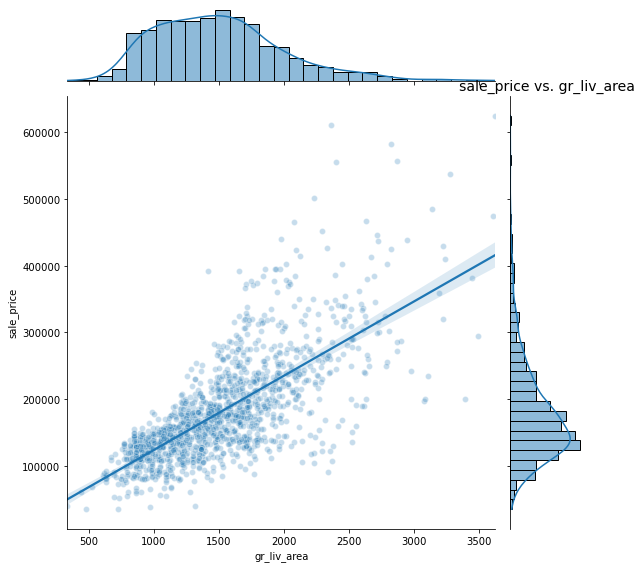

In [70]:
joint(train, 'gr_liv_area', 'sale_price')

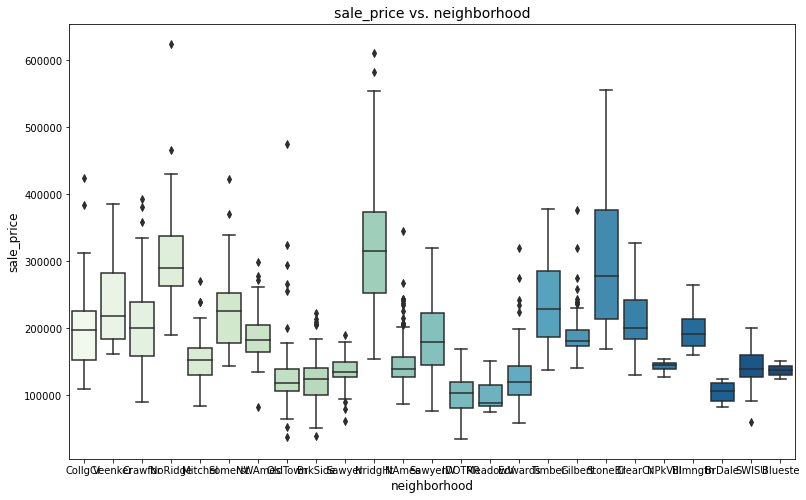

In [71]:
box(train, 'neighborhood', 'sale_price')

However, analyzing the correlations reveal other features to be important predictors.

In [72]:
train.corr()[['sale_price']].sort_values(by='sale_price', ascending=False)

sale_price
sale_price         1.000000
overall_qual       0.800858
gr_liv_area        0.720516
exter_qual         0.694628
kitchen_qual       0.666217
garage_cars        0.649256
total_bsmt_sf      0.646584
garage_area        0.636964
1st_flr_sf         0.625235
bsmt_qual          0.592073
full_bath          0.559048
garage_finish      0.556808
tot_rms_abv_grd    0.537462
fireplace_qu       0.528841
mas_vnr_area       0.473650
fireplaces         0.466765
heating_qc         0.435081
bsmt_fin_sf1       0.395923
open_porch_sf      0.330361
wood_deck_sf       0.322538
2nd_flr_sf         0.297301
half_bath          0.282925
garage_qual        0.281419
lot_area           0.269866
central_air        0.258056
paved_drive        0.237083
bsmt_full_bath     0.235697
bsmt_unf_sf        0.220678
bsmt_cond          0.219340
lot_frontage       0.201706
bedroom_abv_gr     0.160542
screen_porch       0.118324
functional         0.109250
exter_cond         0.021999
bsmt_fin_sf2      -0.008900
bsmt_half_bath    -0.036792
overall_cond      -0.080202
ms_sub_class      -0.088160
enclosed_porch    -0.129774
lot_shape         -0.270256
garage_age        -0.398513
remod_age         -0.523102
age               -0.535507

Text(0.5, 0.98, 'numeric heatmap')

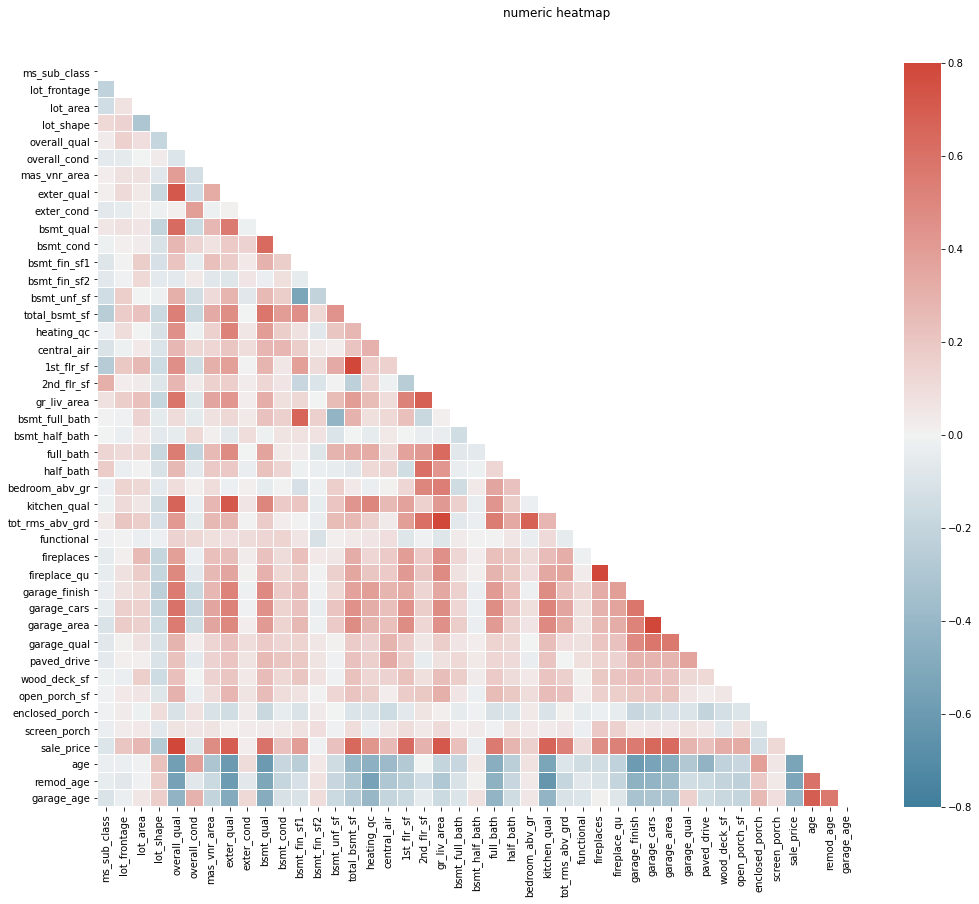

In [73]:
# https://jovianlin.io/data-visualization-seaborn-part-2/

corr = train.corr()

fig, (ax) = plt.subplots(1, 1, figsize=(17, 13))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

heatmap = sns.heatmap(corr, 
                      mask=mask, 
                      ax=ax, 
                      cmap= sns.diverging_palette(230, 15, as_cmap=True),
                      vmin=-0.8, 
                      vmax=0.8, 
                      fmt='.1f',
                      linewidths=.05)

fig.subplots_adjust(top=.92)
fig.suptitle('numeric heatmap')

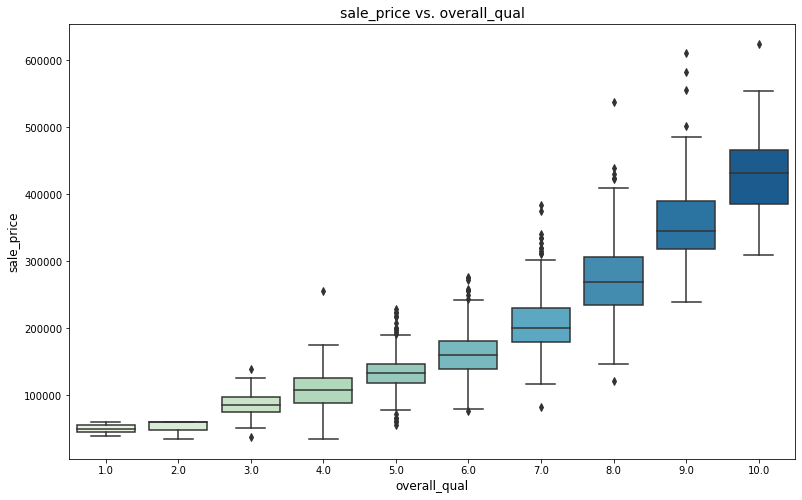

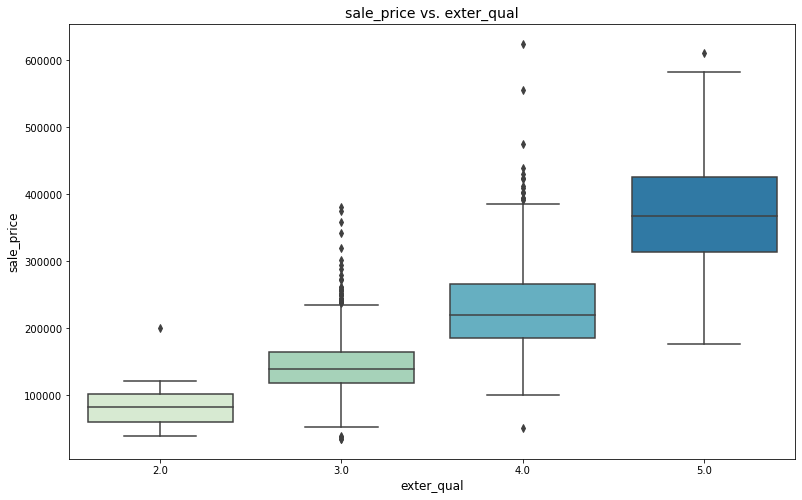

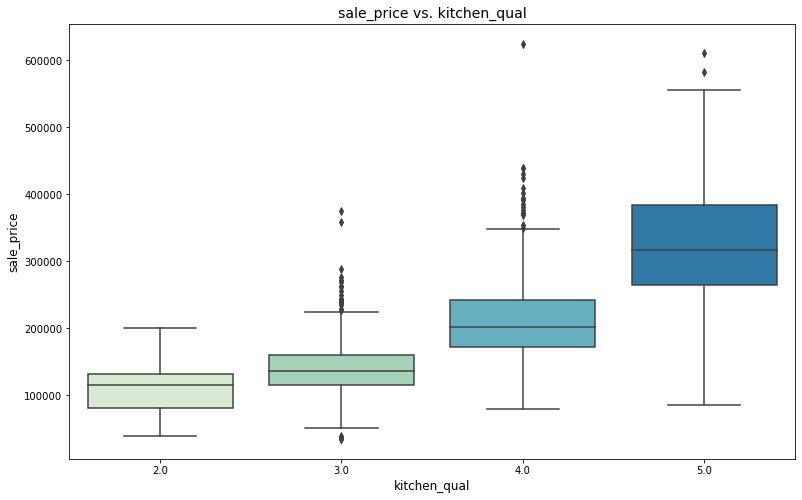

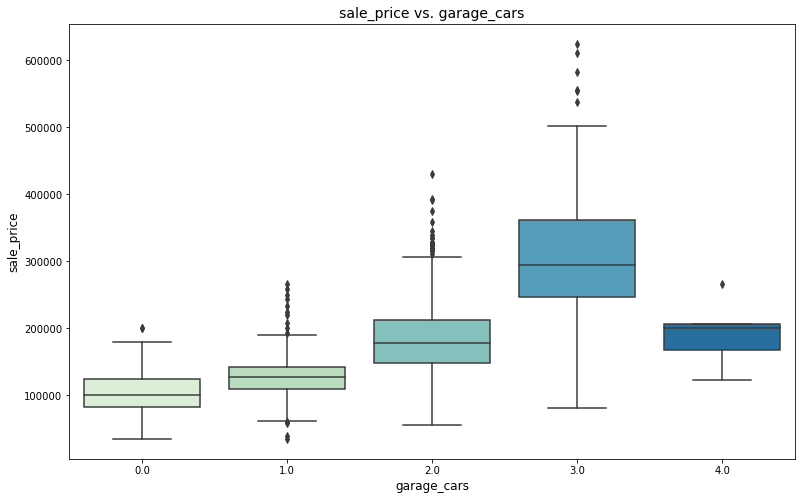

In [74]:
for x in ['overall_qual', 'exter_qual', 'kitchen_qual', 'garage_cars']:
    box(train, x, 'sale_price')

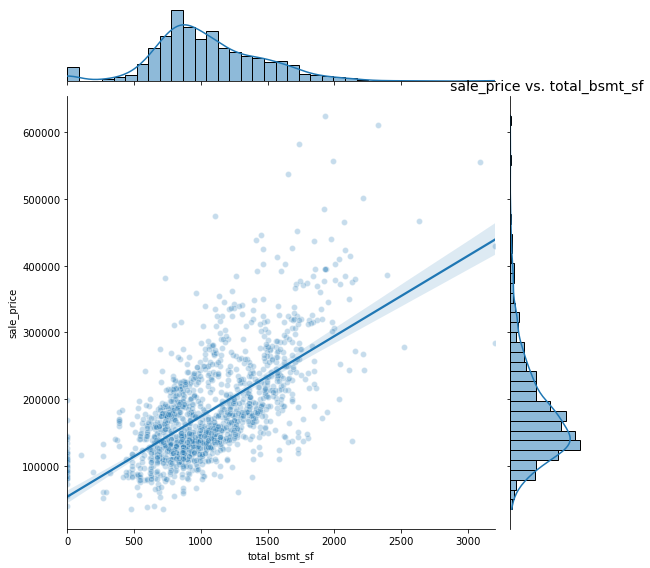

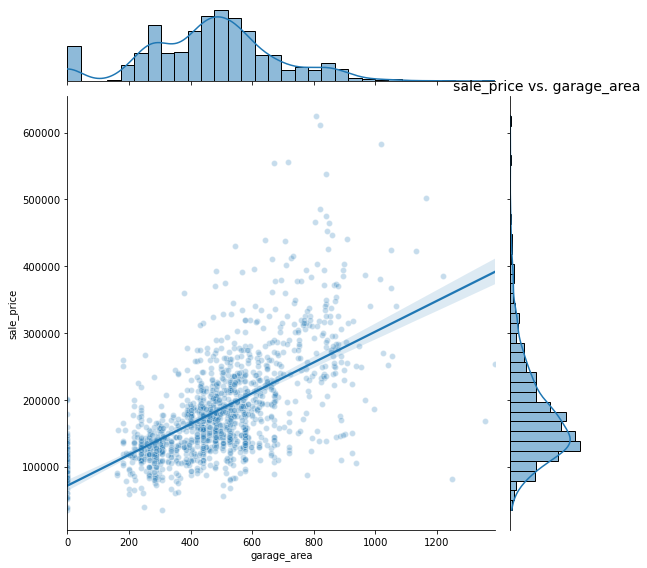

In [75]:
for x in ['total_bsmt_sf', 'garage_area']:
    joint(train, x, 'sale_price')

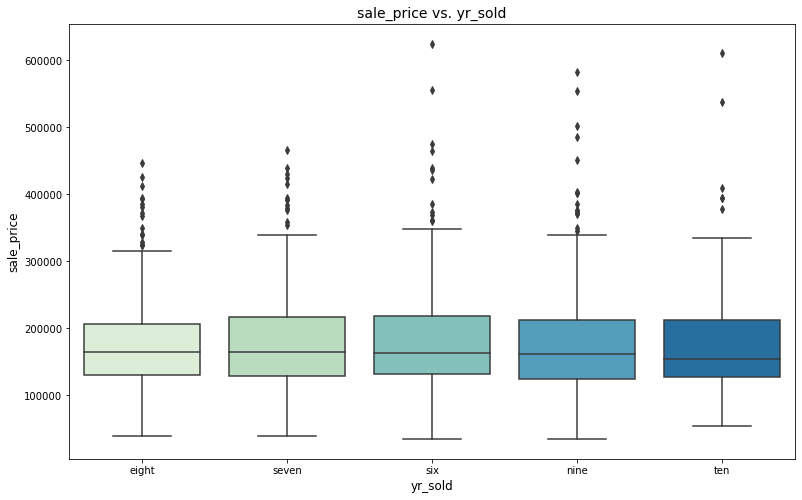

In [76]:
box(train, 'yr_sold', 'sale_price')

In [77]:
joint(train, 'age', 'sale_price')

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, StandardScaler, OneHotEncoder, FunctionTransformer, QuantileTransformer, RobustScaler
from sklearn.pipeline import Pipeline

from category_encoders import TargetEncoder

from scipy.stats import norm

import eli5

pd.set_option('display.max_rows',100)

Let's first take a look at the target variable.

In [83]:
from scipy.stats import norm

In [92]:
def compare_to_norm(X, name=None):
    sns.distplot(X, fit=norm);
    mean, stdev = norm.fit(X)
    print(f'mean = {mean:.1f} and stdev = {stdev:.1f}')
    plt.legend(['norm'], loc='best')
    plt.ylabel('frequency')
    if name:
        plt.title(f'{name} distribution')
    else:
        plt.title(f'{X.name} distribution')
    plt.show()

mean = 180151.2 and stdev = 76670.2


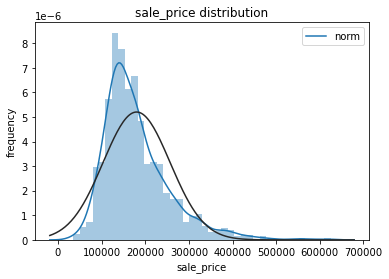

In [94]:
compare_to_norm(train['sale_price'])

Looking at the skew of the target distribution, we most likely have to transform to make it more normally distributed.

In [86]:
from sklearn.preprocessing import FunctionTransformer

mean = 12.0 and stdev = 0.4


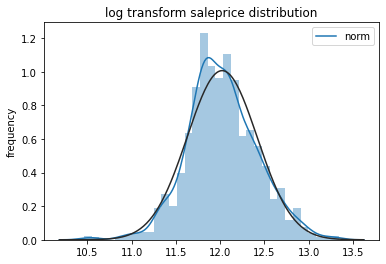

In [96]:
transformer = FunctionTransformer(np.log1p, np.expm1, validate=True, check_inverse=True)
transformer.fit(train[['sale_price']])      # FunctionTransformer needs 2D input
transformed_target = transformer.fit_transform(train[['sale_price']])
compare_to_norm(transformed_target, 'log transform saleprice')

This is much closer to a normal distribution, suggesting we should fit our model to the log-transformed target.

## Single Linear Regression

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
np.log1p(train['saleprice'])

0       11.779136
1       12.301387
2       11.599112
3       12.066816
4       11.838633
          ...    
2046    12.607369
2047    11.320566
2048    12.083911
2049    11.877576
2050    12.149508
Name: saleprice, Length: 2047, dtype: float64

In [97]:
def adjusted_r2(r2, obs, feats):
    
    # adjust r2 value based on number of observations and number of features
    adjusted = 1 - (1 - r2) * (obs - 1) / (obs - feats - 1)
    
    return adjusted

In [98]:
def print_regression_stats(model, df, feature_cols=None, target_col='sale_price', test_size=0.7, random_state=111):
    
    if feature_cols:
        features = df.drop(columns=target_col)[feature_cols]
    else:
        features = df.drop(columns=target_col)
    target = df[target_col]
    target = np.log1p(target)

    X_train, X_test, y_train, y_test = train_test_split(
        features, target, random_state=random_state, test_size=test_size)
    
    model.fit(X_train, y_train)

    y_hat_train = np.expm1(model.predict(X_train))
    y_hat_test = np.expm1(model.predict(X_test))
    
    adj_train = adjusted_r2(model.score(X_train, y_train), X_train.shape[0], X_train.shape[1])
    adj_test = adjusted_r2(model.score(X_test, y_test), X_test.shape[0], X_test.shape[1])

    print(f'train adj r2: {adj_train}')
    print(f'train rmse: {mean_squared_error(np.expm1(y_train), y_hat_train) ** 0.5}')
    print(f'test adj r2: {adj_test}')
    print(f'test rmse: {mean_squared_error(np.expm1(y_test), y_hat_test) ** 0.5}')
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x = y_hat_test,
        y = np.expm1(y_test) - y_hat_test
    )
    plt.title('residuals vs. predicted', fontsize=12)
    plt.xlabel('predicted values', fontsize=10)
    plt.hlines(y = 0, xmin = y_hat_test.min(), xmax = y_hat_test.max(), color = "red")
    plt.show()

train adj r2: 0.6491058550010645
train rmse: 44127.00460602327
test adj r2: 0.6793195867840501
test rmse: 42262.22903603627


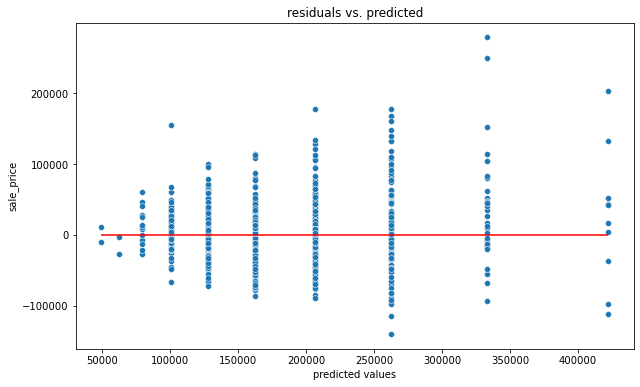

In [106]:
feature_cols = ['overall_qual']

print_regression_stats(LinearRegression(), train, feature_cols, 'sale_price')

train adj r2: 0.5042518721664742
train rmse: 53854.06257172854
test adj r2: 0.5202779374142001
test rmse: 55467.17795494838


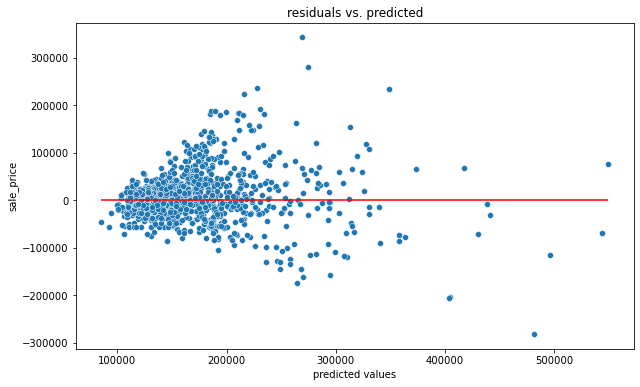

In [107]:
feature_cols = ['gr_liv_area']

print_regression_stats(LinearRegression(), train, feature_cols, 'sale_price')

Our residuals do not appear to be:
- random
- evenly variant as a function of our predicted value
- insensitive to outliers

Therefore, we should attempt:
- using better (or more) features
- feature engineering
- further preprocessing of our data

## multiple linear regression

train adj r2: 0.7638650363248243
train rmse: 37112.47306001985
test adj r2: 0.7676743576974336
test rmse: 34784.15026566737


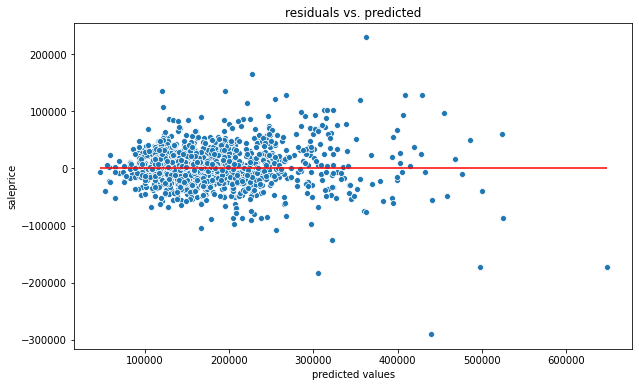

In [ ]:
feature_cols = ['gr_liv_area', 'overall_qual']

print_regression_stats(LinearRegression(), train, feature_cols, 'saleprice')

train adj r2: 0.7826270943975648
train rmse: 34773.79570831269
test adj r2: 0.7785258237763518
test rmse: 32962.3152034828


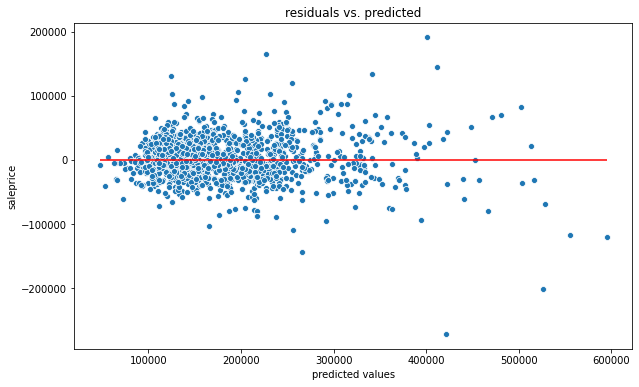

In [ ]:
feature_cols = ['gr_liv_area', 'overall_qual', 'exter_qual']

print_regression_stats(LinearRegression(), train, feature_cols, 'saleprice')

train adj r2: 0.915603160805666
train rmse: 21096.92073111763
test adj r2: 0.8932309601995221
test rmse: 24047.829362684362


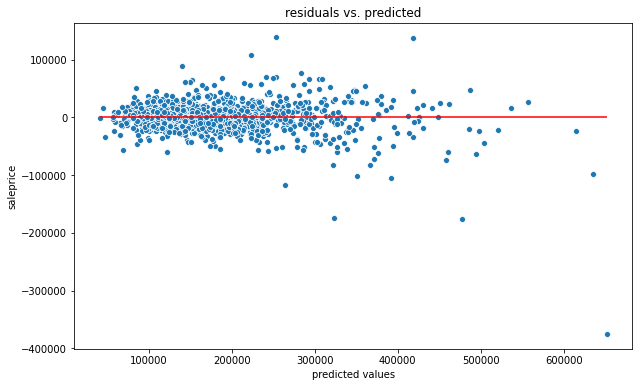

In [ ]:
feature_cols = features.select_dtypes(exclude=['O']).columns    # all numeric columns

print_regression_stats(LinearRegression(), train, feature_cols, 'saleprice')

train adj r2: 0.915603160805666
train rmse: 21096.920731117432
test adj r2: 0.8932309601995306
test rmse: 24047.829362684595


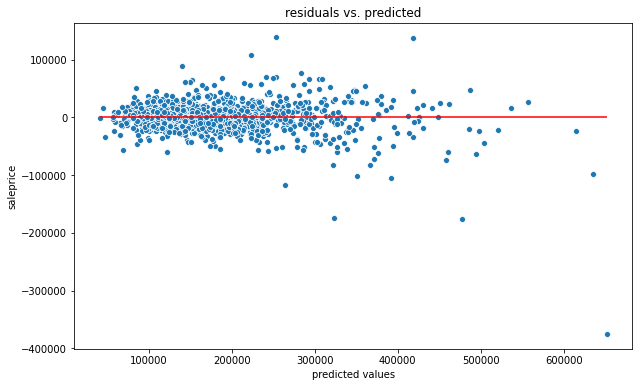

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', RobustScaler(), train.drop(columns='saleprice').select_dtypes(exclude=['O']).columns.values)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', LinearRegression())
])

print_regression_stats(pipe, train, feature_cols, 'saleprice')

Going at this one-by-one is a time-consuming and probably fruitless task. We will discuss how to 'automate' this process later. The main takeaway is that we can see that adding in more features does improve our scores.

## using categorical features

One-hot encoding is the typical method of dealing with nominal features. However, as mentioned earlier, some of the features have high cardinality. This may introduce problems when cross-validating:

In [ ]:
# num_trans = Pipeline([
#     ('scale', )
# ])

# cat_trans = Pipeline([
#     ('onehot', OneHotEncoder(categories="auto",
#                              handle_unknown='ignore',
#                              sparse=False))
# ])

preprocessor = ColumnTransformer(transformers=[
    ('num', RobustScaler(), train.drop(columns='saleprice').select_dtypes(exclude=['O']).columns.values),
    ('cat', OneHotEncoder(), train.drop(columns='saleprice').select_dtypes(include=['O']).columns.values)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', LinearRegression())
])

print_regression_stats(pipe, train)

ValueError: ignored

We can introduce another way of encoding, called **additive smoothing** (described [here](
https://maxhalford.github.io/blog/target-encoding/)). The `sklearn`-compatible package `category_encoders` actually has a **target encoding** with smoothing option that works similarly.

In [ ]:
to_target_encode = [train[col].value_counts().min() < 10 for col in train.select_dtypes(include=['O']).columns.values]
to_onehot = [not b for b in to_target_encode]
target_encode_col = train.select_dtypes(include=['O']).columns.values[to_target_encode]
onehot_col = train.select_dtypes(include=['O']).columns.values[to_onehot]
print(target_encode_col)
print()
print(onehot_col)

['ms_subclass' 'ms_zoning' 'lot_config' 'neighborhood' 'condition_1'
 'house_style' 'roof_style' 'exterior_1st' 'exterior_2nd' 'foundation'
 'electrical' 'sale_type']

['land_contour' 'bldg_type' 'mas_vnr_type' 'bsmt_exposure'
 'bsmtfin_type_1' 'bsmtfin_type_2' 'garage_type' 'mo_sold' 'yr_sold']


train adj r2: 0.9307854682125101
train rmse: 18635.815521508917
test adj r2: 0.8965241181719007
test rmse: 21600.97861902483


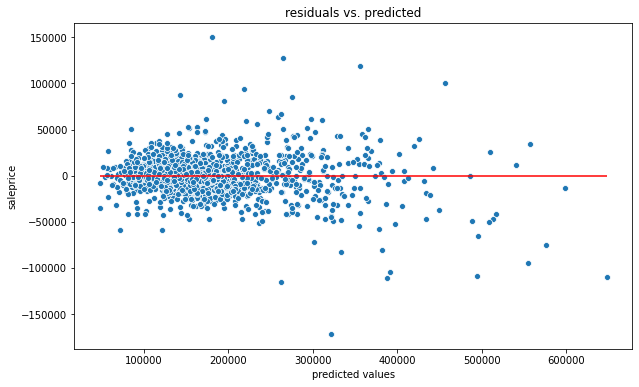

In [ ]:
num_trans = Pipeline([
    ('scale', RobustScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, train.drop(columns='saleprice').select_dtypes(exclude=['O']).columns.values),
    ('ohe', OneHotEncoder(categories="auto", handle_unknown='ignore', sparse=False), onehot_col),
    ('target', TargetEncoder(cols=target_encode_col), target_encode_col)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', LinearRegression())
])

print_regression_stats(pipe, train)

While the residuals still do not appear to be homoskedastic, we get a small improvement incorporating all of the categorical features and using target encoding / additive smoothing.

Getting feature names from pipelines is a little tricky, so we'll follow [this guide](https://towardsdatascience.com/extracting-feature-importances-from-scikit-learn-pipelines-18c79b4ae09a).

In [ ]:
def print_regression_stats_2(model, df, feature_cols=None, target_col='saleprice', test_size=0.7, random_state=111):

    if feature_cols:
        features = df.drop(columns=target_col)[feature_cols]
    else:
        features = df.drop(columns=target_col)
    target = df[target_col]
    target = np.log1p(target)

    X_train, X_test, y_train, y_test = train_test_split(
        features, target, random_state=random_state, test_size=test_size)
    
    model.fit(X_train, y_train)

    y_hat_train = np.expm1(model.predict(X_train))
    y_hat_test = np.expm1(model.predict(X_test))
    
    adj_train = adjusted_r2(model.score(X_train, y_train), X_train.shape[0], X_train.shape[1])
    adj_test = adjusted_r2(model.score(X_test, y_test), X_test.shape[0], X_test.shape[1])

    print(f'train adj r2: {adj_train}')
    print(f'train rmse: {mean_squared_error(np.expm1(y_train), y_hat_train) ** 0.5}')
    print(f'test adj r2: {adj_test}')
    print(f'test rmse: {mean_squared_error(np.expm1(y_test), y_hat_test) ** 0.5}')

    try:
        alpha = model.named_steps['estimator'].alpha_
        ratio = model.named_steps['estimator'].l1_ratio_
        print(f'alpha: {alpha}')
        print(f'l1 ratio: {ratio}')
    except:
        print()
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x = y_hat_test,
        y = np.expm1(y_test) - y_hat_test
    )
    plt.title('residuals vs. predicted', fontsize=12)
    plt.xlabel('predicted values', fontsize=10)
    plt.hlines(y = 0, xmin = y_hat_test.min(), xmax = y_hat_test.max(), color = "red")
    plt.show()

    onehot_columns = list(model.named_steps['preprocessor'].named_transformers_['ohe'].get_feature_names(input_features=onehot_col))
    target_columns = list(model.named_steps['preprocessor'].named_transformers_['target'].get_feature_names())
    numeric_features_list = list(features.select_dtypes(exclude=['O']).columns.values)
    numeric_features_list.extend(onehot_columns)
    numeric_features_list.extend(target_columns)

    return eli5.explain_weights(model.named_steps['estimator'], top=50, feature_names=numeric_features_list)

train adj r2: 0.9233382120704784
train rmse: 19814.081628755346
test adj r2: 0.8998143292863154
test rmse: 21410.02596896072
alpha: 0.0011659144011798312


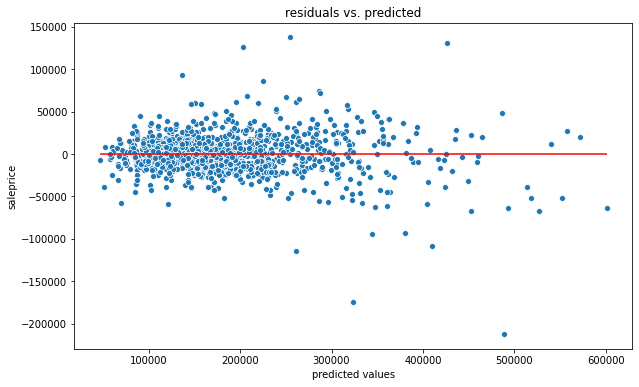

Explanation(estimator="LassoCV(alphas=array([1.00000000e-04, 1.84784980e-04, 3.41454887e-04, 6.30957344e-04,\n       1.16591440e-03, 2.15443469e-03, 3.98107171e-03, 7.35642254e-03,\n       1.35935639e-02, 2.51188643e-02, 4.64158883e-02, 8.57695899e-02,\n       1.58489319e-01, 2.92864456e-01, 5.41169527e-01, 1.00000000e+00]),\n        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,\n        n_alphas=100, n_jobs=None, normalize=False, positive=False,\n        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,\n        verbose=False)", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=9.006552803570324, std=None, value=None), FeatureWeight(feature='gr_liv_area', weight=0.14219782870003742, std=None, value=None), FeatureWeight(feature='overall_qual', weight=0.10783848218262841, std=None, value=None), FeatureWeight(feature='bsmtfin_sf_1', weight=0.06706163637341825, std=None, value=None), FeatureWeight(feature='ms_zoning', weight=0.06230148316505898, std=None, value=None), FeatureWeight(feature='ms_subclass', weight=0.0622372797460158, std=None, value=None), FeatureWeight(feature='bsmt_exposure_3', weight=0.05854757052288729, std=None, value=None), FeatureWeight(feature='neighborhood', weight=0.05555423230289356, std=None, value=None), FeatureWeight(feature='bldg_type_1Fam', weight=0.04579603536918474, std=None, value=None), FeatureWeight(feature='central_air', weight=0.04445912778384098, std=None, value=None), FeatureWeight(feature='total_bsmt_sf', weight=0.04398679364604884, std=None, value=None), FeatureWeight(feature='sale_type', weight=0.04034827204017793, std=None, value=None), FeatureWeight(feature='overall_cond', weight=0.03720986997951461, std=None, value=None), FeatureWeight(feature='kitchen_qual', weight=0.03587048537775888, std=None, value=None), FeatureWeight(feature='exter_qual', weight=0.031378754049037776, std=None, value=None), FeatureWeight(feature='garage_type_Detchd', weight=0.028217263478903656, std=None, value=None), FeatureWeight(feature='functional', weight=0.02658305661952189, std=None, value=None), FeatureWeight(feature='fireplaces', weight=0.02357630689080328, std=None, value=None), FeatureWeight(feature='garage_area', weight=0.0221170616665796, std=None, value=None), FeatureWeight(feature='paved_drive', weight=0.021698671342390785, std=None, value=None), FeatureWeight(feature='fireplace_qu', weight=0.020459643793359628, std=None, value=None), FeatureWeight(feature='bsmt_full_bath', weight=0.02023864656473348, std=None, value=None), FeatureWeight(feature='condition_1', weight=0.020231344538729826, std=None, value=None), FeatureWeight(feature='1st_flr_sf', weight=0.019287101850973497, std=None, value=None), FeatureWeight(feature='lot_area', weight=0.01646420795971155, std=None, value=None), FeatureWeight(feature='mo_sold_jun', weight=0.01599919477527692, std=None, value=None), FeatureWeight(feature='heating_qc', weight=0.012595920677297964, std=None, value=None), FeatureWeight(feature='totrms_abvgrd', weight=0.012469264774634649, std=None, value=None), FeatureWeight(feature='full_bath', weight=0.011578016787305708, std=None, value=None), FeatureWeight(feature='garage_age', weight=0.011507674480242525, std=None, value=None), FeatureWeight(feature='mo_sold_jul', weight=0.010168648047725675, std=None, value=None), FeatureWeight(feature='yr_sold_six', weight=

In [ ]:
print_regression_stats_2(pipe, train)

# Regularized Linear Regression

train adj r2: 0.9233382120704784
train rmse: 19814.081628755346
test adj r2: 0.8998143292863154
test rmse: 21410.02596896072
alpha: 0.0011659144011798312


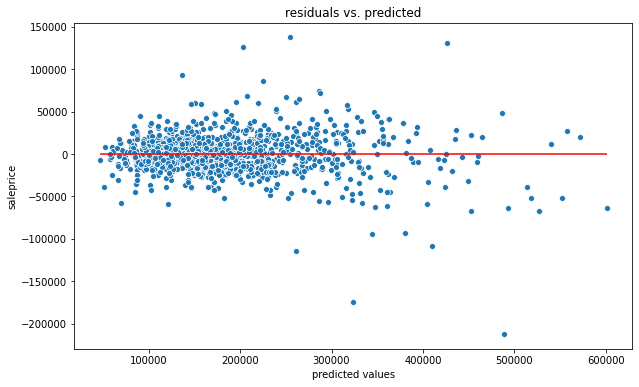

Explanation(estimator="LassoCV(alphas=array([1.00000000e-04, 1.84784980e-04, 3.41454887e-04, 6.30957344e-04,\n       1.16591440e-03, 2.15443469e-03, 3.98107171e-03, 7.35642254e-03,\n       1.35935639e-02, 2.51188643e-02, 4.64158883e-02, 8.57695899e-02,\n       1.58489319e-01, 2.92864456e-01, 5.41169527e-01, 1.00000000e+00]),\n        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,\n        n_alphas=100, n_jobs=None, normalize=False, positive=False,\n        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,\n        verbose=False)", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=9.006552803570324, std=None, value=None), FeatureWeight(feature='gr_liv_area', weight=0.14219782870003742, std=None, value=None), FeatureWeight(feature='overall_qual', weight=0.10783848218262841, std=None, value=None), FeatureWeight(feature='bsmtfin_sf_1', weight=0.06706163637341825, std=None, value=None), FeatureWeight(feature='ms_zoning', weight=0.06230148316505898, std=None, value=None), FeatureWeight(feature='ms_subclass', weight=0.0622372797460158, std=None, value=None), FeatureWeight(feature='bsmt_exposure_3', weight=0.05854757052288729, std=None, value=None), FeatureWeight(feature='neighborhood', weight=0.05555423230289356, std=None, value=None), FeatureWeight(feature='bldg_type_1Fam', weight=0.04579603536918474, std=None, value=None), FeatureWeight(feature='central_air', weight=0.04445912778384098, std=None, value=None), FeatureWeight(feature='total_bsmt_sf', weight=0.04398679364604884, std=None, value=None), FeatureWeight(feature='sale_type', weight=0.04034827204017793, std=None, value=None), FeatureWeight(feature='overall_cond', weight=0.03720986997951461, std=None, value=None), FeatureWeight(feature='kitchen_qual', weight=0.03587048537775888, std=None, value=None), FeatureWeight(feature='exter_qual', weight=0.031378754049037776, std=None, value=None), FeatureWeight(feature='garage_type_Detchd', weight=0.028217263478903656, std=None, value=None), FeatureWeight(feature='functional', weight=0.02658305661952189, std=None, value=None), FeatureWeight(feature='fireplaces', weight=0.02357630689080328, std=None, value=None), FeatureWeight(feature='garage_area', weight=0.0221170616665796, std=None, value=None), FeatureWeight(feature='paved_drive', weight=0.021698671342390785, std=None, value=None), FeatureWeight(feature='fireplace_qu', weight=0.020459643793359628, std=None, value=None), FeatureWeight(feature='bsmt_full_bath', weight=0.02023864656473348, std=None, value=None), FeatureWeight(feature='condition_1', weight=0.020231344538729826, std=None, value=None), FeatureWeight(feature='1st_flr_sf', weight=0.019287101850973497, std=None, value=None), FeatureWeight(feature='lot_area', weight=0.01646420795971155, std=None, value=None), FeatureWeight(feature='mo_sold_jun', weight=0.01599919477527692, std=None, value=None), FeatureWeight(feature='heating_qc', weight=0.012595920677297964, std=None, value=None), FeatureWeight(feature='totrms_abvgrd', weight=0.012469264774634649, std=None, value=None), FeatureWeight(feature='full_bath', weight=0.011578016787305708, std=None, value=None), FeatureWeight(feature='garage_age', weight=0.011507674480242525, std=None, value=None), FeatureWeight(feature='mo_sold_jul', weight=0.010168648047725675, std=None, value=None), FeatureWeight(feature='yr_sold_six', weight=

In [ ]:
num_trans = Pipeline([
    ('scale', RobustScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, train.drop(columns='saleprice').select_dtypes(exclude=['O']).columns.values),
    ('ohe', OneHotEncoder(categories="auto", handle_unknown='ignore', sparse=False), onehot_col),
    ('target', TargetEncoder(cols=target_encode_col), target_encode_col)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', LassoCV(
        alphas=np.logspace(-4, 0, 16),
        cv=5
    ))
])

print_regression_stats_2(pipe, train)

train adj r2: 0.9257196841744338
train rmse: 19320.913047672722
test adj r2: 0.899743554842844
test rmse: 21268.91503127153
alpha: 15.848931924611142


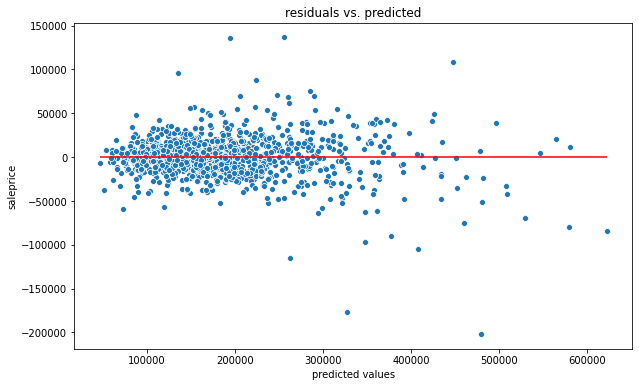

Explanation(estimator='RidgeCV(alphas=array([1.00000000e-02, 1.84784980e-02, 3.41454887e-02, 6.30957344e-02,\n       1.16591440e-01, 2.15443469e-01, 3.98107171e-01, 7.35642254e-01,\n       1.35935639e+00, 2.51188643e+00, 4.64158883e+00, 8.57695899e+00,\n       1.58489319e+01, 2.92864456e+01, 5.41169527e+01, 1.00000000e+02]),\n        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,\n        store_cv_values=False)', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=7.8294800391686135, std=None, value=None), FeatureWeight(feature='overall_qual', weight=0.09592846670941757, std=None, value=None), FeatureWeight(feature='gr_liv_area', weight=0.09010582444722282, std=None, value=None), FeatureWeight(feature='ms_subclass', weight=0.05502309990482605, std=None, value=None), FeatureWeight(feature='1st_flr_sf', weight=0.05479297930545252, std=None, value=None), FeatureWeight(feature='ms_zoning', weight=0.054360827090666586, std=None, value=None), FeatureWeight(feature='central_air', weight=0.05303216492672065, std=None, value=None), FeatureWeight(feature='total_bsmt_sf', weight=0.05135209176306852, std=None, value=None), FeatureWeight(feature='neighborhood', weight=0.05022729273833315, std=None, value=None), FeatureWeight(feature='bsmt_exposure_3', weight=0.04485170192073682, std=None, value=None), FeatureWeight(feature='sale_type', weight=0.04312571217754743, std=None, value=None), FeatureWeight(feature='2nd_flr_sf', weight=0.04299152040897161, std=None, value=None), FeatureWeight(feature='bsmtfin_sf_1', weight=0.04209001817035895, std=None, value=None), FeatureWeight(feature='bldg_type_1Fam', weight=0.03795740911559237, std=None, value=None), FeatureWeight(feature='condition_1', weight=0.03781319129849031, std=None, value=None), FeatureWeight(feature='kitchen_qual', weight=0.035692178258737696, std=None, value=None), FeatureWeight(feature='overall_cond', weight=0.03399547652424682, std=None, value=None), FeatureWeight(feature='exter_qual', weight=0.030887213057224656, std=None, value=None), FeatureWeight(feature='garage_type_Detchd', weight=0.028898163288056014, std=None, value=None), FeatureWeight(feature='paved_drive', weight=0.027827484729171757, std=None, value=None), FeatureWeight(feature='functional', weight=0.02645502569200238, std=None, value=None), FeatureWeight(feature='full_bath', weight=0.026355834712957618, std=None, value=None), FeatureWeight(feature='roof_style', weight=0.025407152852891184, std=None, value=None), FeatureWeight(feature='fireplace_qu', weight=0.02470114874046699, std=None, value=None), FeatureWeight(feature='bsmt_full_bath', weight=0.022360479433743377, std=None, value=None), FeatureWeight(feature='garage_area', weight=0.022351285299642296, std=None, value=None), FeatureWeight(feature='fireplaces', weight=0.022098976930745435, std=None, value=None), FeatureWeight(feature='exterior_1st', weight=0.021371857642533677, std=None, value=None), FeatureWeight(feature='totrms_abvgrd', weight=0.020827154835950476, std=None, value=None), FeatureWeight(feature='foundation', weight=0.020637967677629338, std=None, value=None), FeatureWeight(feature='mo_sold_jun', weight=0.019698586634269894, std=None, value=None), FeatureWeight(feature='house_style', weight=0.01754720979911817, std=None, value=None), FeatureWeight(feature='heating_qc', weight=0.01683140626798321, std=None, value=

In [ ]:
num_trans = Pipeline([
    ('scale', RobustScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, train.drop(columns='saleprice').select_dtypes(exclude=['O']).columns.values),
    ('ohe', OneHotEncoder(categories="auto", handle_unknown='ignore', sparse=False), onehot_col),
    ('target', TargetEncoder(cols=target_encode_col), target_encode_col)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', RidgeCV(
        alphas=np.logspace(-2, 2, 16),
        cv=5
    ))
])

print_regression_stats_2(pipe, train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.786162115924355, tolerance: 0.008406230570582205
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.70114186774831, tolerance: 0.008406230570582205
  tol, rng, random, positive)
/usr/

train adj r2: 0.9216360373673936
train rmse: 19969.308895772814
test adj r2: 0.8999206904815029
test rmse: 21423.451399725276
alpha: 0.011721022975334805
l1 ratio: 0.1


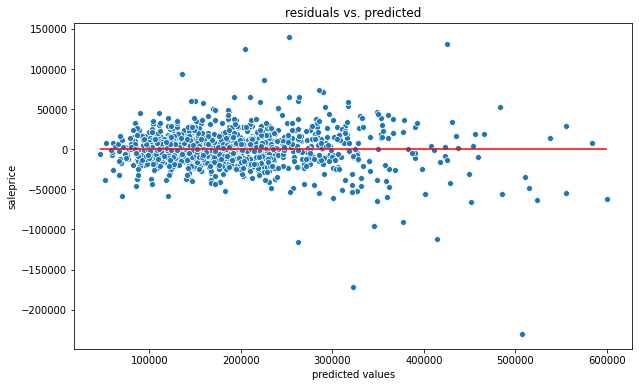

Explanation(estimator="ElasticNetCV(alphas=array([1.00000000e-04, 1.61026203e-04, 2.59294380e-04, 4.17531894e-04,\n       6.72335754e-04, 1.08263673e-03, 1.74332882e-03, 2.80721620e-03,\n       4.52035366e-03, 7.27895384e-03, 1.17210230e-02, 1.88739182e-02,\n       3.03919538e-02, 4.89390092e-02, 7.88046282e-02, 1.26896100e-01,\n       2.04335972e-01, 3.29034456e-01, 5.29831691e-01, 8.53167852e-01,\n       1.37382380e+00, 2.212216...\n       9.23670857e+00, 1.48735211e+01, 2.39502662e+01, 3.85662042e+01,\n       6.21016942e+01, 1.00000000e+02]),\n             copy_X=True, cv=5, eps=0.001, fit_intercept=True,\n             l1_ratio=array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,\n       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),\n             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,\n             positive=False, precompute='auto', random_state=None,\n             selection='cyclic', tol=0.0001, verbose=0)", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=9.657117029312708, std=None, value=None), FeatureWeight(feature='gr_liv_area', weight=0.1211622768039972, std=None, value=None), FeatureWeight(feature='overall_qual', weight=0.10466938625671429, std=None, value=None), FeatureWeight(feature='bsmtfin_sf_1', weight=0.06234537637046055, std=None, value=None), FeatureWeight(feature='ms_subclass', weight=0.05205544494022292, std=None, value=None), FeatureWeight(feature='neighborhood', weight=0.0514252839450165, std=None, value=None), FeatureWeight(feature='bsmt_exposure_3', weight=0.050366248019051325, std=None, value=None), FeatureWeight(feature='ms_zoning', weight=0.04671346633508707, std=None, value=None), FeatureWeight(feature='total_bsmt_sf', weight=0.04292572031221965, std=None, value=None), FeatureWeight(feature='bldg_type_1Fam', weight=0.04107044520574361, std=None, value=None), FeatureWeight(feature='central_air', weight=0.0393474751940621, std=None, value=None), FeatureWeight(feature='overall_cond', weight=0.03619378787991631, std=None, value=None), FeatureWeight(feature='kitchen_qual', weight=0.036002333114301184, std=None, value=None), FeatureWeight(feature='exter_qual', weight=0.034101157847278046, std=None, value=None), FeatureWeight(feature='1st_flr_sf', weight=0.0326023430727726, std=None, value=None), FeatureWeight(feature='functional', weight=0.025943898239583596, std=None, value=None), FeatureWeight(feature='sale_type', weight=0.02559509498459347, std=None, value=None), FeatureWeight(feature='fireplaces', weight=0.024929376754812396, std=None, value=None), FeatureWeight(feature='paved_drive', weight=0.023213391632397558, std=None, value=None), FeatureWeight(feature='garage_area', weight=0.022817325096350684, std=None, value=None), FeatureWeight(feature='bsmt_full_bath', weight=0.020413972088196872, std=None, value=None), FeatureWeight(feature='fireplace_qu', weight=0.020242762515412047, std=None, value=None), FeatureWeight(feature='garage_type_Detchd', weight=0.020051861419360262, std=None, value=None), FeatureWeight(feature='lot_area', weight=0.01734919392190432, std=None, value=None), FeatureWeight(feature='heating_qc', weight=0.015901272500297808, std=None, value=None), FeatureWeight(feature='totrms_abvgrd', weight=0.015365200419701821, std=None, value=None), FeatureWeight(feature='2nd_flr_sf', weight=0.014630741029715129, std=None, 

In [ ]:
num_trans = Pipeline([
    ('scale', RobustScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, train.drop(columns='saleprice').select_dtypes(exclude=['O']).columns.values),
    ('ohe', OneHotEncoder(categories="auto", handle_unknown='ignore', sparse=False), onehot_col),
    ('target', TargetEncoder(cols=target_encode_col), target_encode_col)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', ElasticNetCV(
        l1_ratio=np.linspace(0, 1, 21),
        alphas=np.logspace(-4, 2, 30),
        cv=5
    ))
])

print_regression_stats_2(pipe, train)

# Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

train adj r2: 0.9826635988271778
train rmse: 11227.652231962022
test adj r2: 0.8525581502122838
test rmse: 25382.94515949057



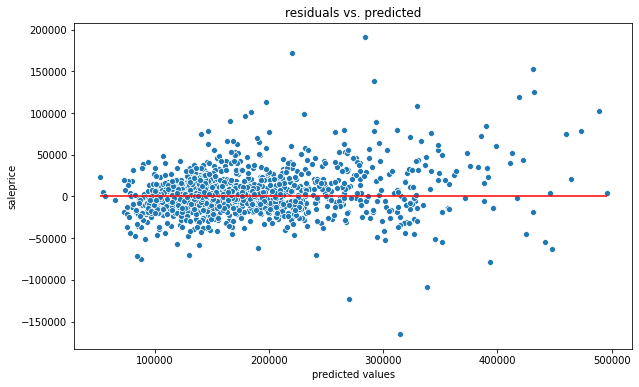

Explanation(estimator="RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',\n                      max_depth=None, max_features='auto', max_leaf_nodes=None,\n                      max_samples=None, min_impurity_decrease=0.0,\n                      min_impurity_split=None, min_samples_leaf=1,\n                      min_samples_split=2, min_weight_fraction_leaf=0.0,\n                      n_estimators=100, n_jobs=None, oob_score=False,\n                      random_state=None, verbose=0, warm_start=False)", description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='overall_qual', weight=0.3395358315392924, std=0.21952946155902545, value=None), FeatureWeight(feature='age', weight=0.10492598351839215, std=0.1885044994044006, value=None), FeatureWeight(feature='gr_liv_area', weight=0.10212172165117539, std=0.050183232842459485, value=None), FeatureWeight(feature='neighborhood', weight=0.08365304185789756, std=0.1394466925477732, value=None), FeatureWeight(feature='garage_area', weight=0.06480506192408962, std=0.059382714247270804, value=None), FeatureWeight(feature='total_bsmt_sf', weight=0.04315704579363052, std=0.03364062209819217, value=None), FeatureWeight(feature='1st_flr_sf', weight=0.03030657045583187, std=0.03349637819565058, value=None), FeatureWeight(feature='bsmtfin_sf_1', weight=0.02365852361043397, std=0.02480761097747742, value=None), FeatureWeight(feature='central_air', weight=0.020662072777378505, std=0.031903651517124085, value=None), FeatureWeight(feature='kitchen_qual', weight=0.018807267178257352, std=0.0816781904344081, value=None), FeatureWeight(feature='lot_area', weight=0.017972650852631243, std=0.01376985207583079, value=None), FeatureWeight(feature='ms_subclass', weight=0.017549909342295427, std=0.024337905031696427, value=None), FeatureWeight(feature='remod_age', weight=0.01484908761968526, std=0.015033221937869412, value=None), FeatureWeight(feature='bsmt_qual', weight=0.013526055257478319, std=0.03317971165763337, value=None), FeatureWeight(feature='yr_sold_nine', weight=0.007614052124778454, std=0.010183788992279383, value=None), FeatureWeight(feature='2nd_flr_sf', weight=0.007165545264907055, std=0.008783552292725228, value=None), FeatureWeight(feature='fireplace_qu', weight=0.007115925189327494, std=0.01602905361675817, value=None), FeatureWeight(feature='open_porch_sf', weight=0.005586189733651425, std=0.009366441470326154, value=None), FeatureWeight(feature='overall_cond', weight=0.004417884034702184, std=0.007845214492244314, value=None), FeatureWeight(feature='exter_qual', weight=0.004101894895581395, std=0.007082320643784898, value=None), FeatureWeight(feature='lot_frontage', weight=0.003940120471242234, std=0.0034603825538812765, value=None), FeatureWeight(feature='bsmt_unf_sf', weight=0.003713094619062616, std=0.0027257721918667556, value=None), FeatureWeight(feature='garage_age', weight=0.003299753741014075, std=0.0033982982721268637, value=None), FeatureWeight(feature='heating_qc', weight=0.0032528447653594307, std=0.007245230645497215, value=None), FeatureWeight(feature='garage_cars', weight=0.003074573116025008, std=0.017039734485511708, value=None), FeatureWeight(feature='wood_deck_sf', weight=0.003058719645863874, std=0.003110688468904476, value=None), FeatureWeight(feature='condition_1', weight=0.0028666832581780454, std=0.0038541120469155078, value=None), FeatureWeight(feature='fireplaces', weight=0.0026895227723027276, std=0.0085575363856167, value=None), FeatureWeight(feature='totrms_abvgrd', weight=0.002599048008465052, std=0.003444975325214949, value=None), FeatureWeight(feature='mas_vnr_area', weight=0.002300322901399784, std=0.002760048706737515, value=None), FeatureWeight(feature='ms_zoning', weight=0.0021358342346004967, std=0.005715336947523446, value=None), Featu

In [ ]:
num_trans = Pipeline([
    ('scale', RobustScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, train.drop(columns='saleprice').select_dtypes(exclude=['O']).columns.values),
    ('ohe', OneHotEncoder(categories="auto", handle_unknown='ignore', sparse=False), onehot_col),
    ('target', TargetEncoder(cols=target_encode_col), target_encode_col)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', RandomForestRegressor())
])

print_regression_stats_2(pipe, train)

train adj r2: 0.9444928050625644
train rmse: 19323.783366794058
test adj r2: 0.8538934768615607
test rmse: 25824.97826246556



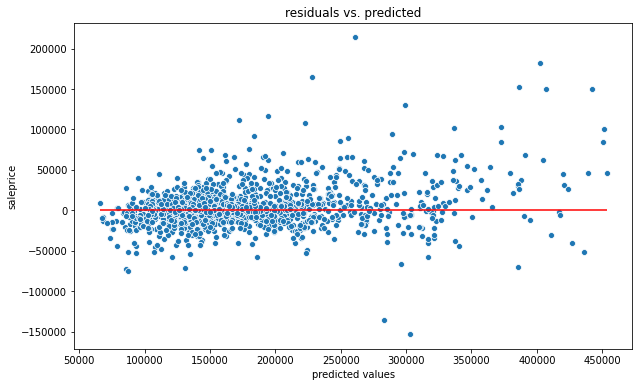

Explanation(estimator="RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',\n                      max_depth=None, max_features=0.5, max_leaf_nodes=None,\n                      max_samples=None, min_impurity_decrease=0.0,\n                      min_impurity_split=None, min_samples_leaf=5,\n                      min_samples_split=2, min_weight_fraction_leaf=0.0,\n                      n_estimators=600, n_jobs=None, oob_score=False,\n                      random_state=None, verbose=0, warm_start=False)", description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='overall_qual', weight=0.24762918281374754, std=0.22719519529747395, value=None), FeatureWeight(feature='age', weight=0.13878398980603307, std=0.21205871926174683, value=None), FeatureWeight(feature='neighborhood', weight=0.1162767144354894, std=0.18041850756884156, value=None), FeatureWeight(feature='gr_liv_area', weight=0.09227371207581221, std=0.05911693990528399, value=None), FeatureWeight(feature='garage_area', weight=0.05749644145367336, std=0.058563052098055235, value=None), FeatureWeight(feature='exter_qual', weight=0.04900138581795649, std=0.13640018863180658, value=None), FeatureWeight(feature='total_bsmt_sf', weight=0.03831780395691132, std=0.03363282578334693, value=None), FeatureWeight(feature='1st_flr_sf', weight=0.03753061099283393, std=0.03787316021313405, value=None), FeatureWeight(feature='kitchen_qual', weight=0.021502322266541196, std=0.08745147682493074, value=None), FeatureWeight(feature='bsmtfin_sf_1', weight=0.020773117000609912, std=0.024638059926154077, value=None), FeatureWeight(feature='bsmt_qual', weight=0.019364357218191703, std=0.06062666950043076, value=None), FeatureWeight(feature='remod_age', weight=0.017665975694662352, std=0.030103292770514482, value=None), FeatureWeight(feature='central_air', weight=0.017487575492066847, std=0.02890369472499904, value=None), FeatureWeight(feature='ms_subclass', weight=0.01605592120150724, std=0.02387592346076752, value=None), FeatureWeight(feature='lot_area', weight=0.015677955916562986, std=0.01609431205897073, value=None), FeatureWeight(feature='garage_cars', weight=0.013190533299332686, std=0.0375309450356428, value=None), FeatureWeight(feature='2nd_flr_sf', weight=0.010596269113569206, std=0.014348505348399236, value=None), FeatureWeight(feature='fireplace_qu', weight=0.008655532711674869, std=0.017933090183738086, value=None), FeatureWeight(feature='fireplaces', weight=0.00815524860281701, std=0.018084401504268245, value=None), FeatureWeight(feature='garage_finish', weight=0.0034741608410768067, std=0.02534207295063979, value=None), FeatureWeight(feature='garage_age', weight=0.003364602341816245, std=0.0052192334669016035, value=None), FeatureWeight(feature='totrms_abvgrd', weight=0.003216944498325796, std=0.00807321635988152, value=None), FeatureWeight(feature='heating_qc', weight=0.0030974392597178423, std=0.00817817964861621, value=None), FeatureWeight(feature='bsmt_unf_sf', weight=0.0029795551817124767, std=0.003771693159241051, value=None), FeatureWeight(feature='mas_vnr_area', weight=0.0028187209625507876, std=0.0064230001307512006, value=None), FeatureWeight(feature='lot_frontage', weight=0.00267947891624667, std=0.0034635616218252696, value=None), FeatureWeight(feature='overall_cond', weight=0.0025493229456167066, std=0.007140590316186147, value=None), FeatureWeight(feature='paved_drive', weight=0.002337523718435498, std=0.008436314930901717, value=None), FeatureWeight(feature='full_bath', weight=0.0022312324450648683, std=0.006847082517788507, value=None), FeatureWeight(feature='open_porch_sf', weight=0.0020202507727430214, std=0.003549525055551788, value=None), FeatureWeight(feature='wood_deck_sf', weight=0.0019721112213124926, std=0.0031895869146945765, value=None), Feature

In [ ]:
num_trans = Pipeline([
    ('scale', RobustScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, train.drop(columns='saleprice').select_dtypes(exclude=['O']).columns.values),
    ('ohe', OneHotEncoder(categories="auto", handle_unknown='ignore', sparse=False), onehot_col),
    ('target', TargetEncoder(cols=target_encode_col), target_encode_col)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', RandomForestRegressor(
        n_estimators=600,
        min_samples_leaf=5,
        max_features=0.5
    ))
])

print_regression_stats_2(pipe, train)

While RandomForestRegressor performs well on training data, it tends to overfit (as many CARTs do) and performs worse than our more bread-and-butter linear regression methods.